In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-06-01 15:27:49.408660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748791669.431388     632 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748791669.438564     632 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.9: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [2]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.5.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [3]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3", 
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, 
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("philschmid/guanaco-sharegpt-style", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

dataset[5]["conversations"]

print(dataset[5]["text"])

unsloth_template = \
    "{{ bos_token }}"\
    "{{ 'You are a helpful assistant to the user\n' }}"\
    "{% for message in messages %}"\
        "{% if message['role'] == 'user' %}"\
            "{{ '>>> User: ' + message['content'] + '\n' }}"\
        "{% elif message['role'] == 'assistant' %}"\
            "{{ '>>> Assistant: ' + message['content'] + eos_token + '\n' }}"\
        "{% endif %}"\
    "{% endfor %}"\
    "{% if add_generation_prompt %}"\
        "{{ '>>> Assistant: ' }}"\
    "{% endif %}"
unsloth_eos_token = "eos_token"

if False:
    tokenizer = get_chat_template(
        tokenizer,
        chat_template = (unsloth_template, unsloth_eos_token,), # You must provide a template and EOS token
        mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
        map_eos_token = True, # Maps <|im_end|> to </s> instead
    )

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the typical wattage of bulb in a lightbox?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The typical wattage of a bulb in a lightbox is 60 watts, although domestic LED bulbs are normally much lower than 60 watts, as they produce the same or greater lumens for less wattage than alternatives. A 60-watt Equivalent LED bulb can be calculated using the 7:1 ratio, which divides 60 watts by 7 to get roughly 9 watts.<|eot_id|><|start_header_id|>user<|end_header_id|>

Rewrite your description of the typical wattage of a bulb in a lightbox to only include the key points in a list format.<|eot_id|>


In [4]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3", 
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"},
)

from datasets import load_dataset

sst2_dataset = load_dataset('glue', 'sst2')

def format_sst2_for_chat(examples):
    texts = []
    for sentence, label in zip(examples['sentence'], examples['label']):
        sentiment = "positive" if label == 1 else "negative"
        
        conversation = [
            {"from": "human", "value": f"Analyze the sentiment of this sentence: {sentence}"},
            {"from": "gpt", "value": sentiment}
        ]
        
        text = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=False)
        texts.append(text)
    
    return {"text": texts}

total_size = len(sst2_dataset['train'])
sample_size = int(0.01 * total_size)  
subset_dataset = sst2_dataset['train'].select(range(sample_size))

formatted_dataset = subset_dataset.map(format_sst2_for_chat, batched=True)

print("Sample đã được format:")
print(formatted_dataset[0]['text'])
print("\n" + "="*50 + "\n")
print(formatted_dataset[1]['text'])

train_size = int(0.9 * len(formatted_dataset))
train_dataset = formatted_dataset.select(range(train_size))
val_dataset = formatted_dataset.select(range(train_size, len(formatted_dataset)))

print(f"\nTotal original dataset size: {total_size}")
print(f"Using 1% subset size: {sample_size}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Sample đã được format:
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Analyze the sentiment of this sentence: hide new secretions from the parental units<|eot_id|><|start_header_id|>assistant<|end_header_id|>

negative<|eot_id|>


<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Analyze the sentiment of this sentence: contains no wit , only labored gags<|eot_id|><|start_header_id|>assistant<|end_header_id|>

negative<|eot_id|>

Total original dataset size: 67349
Using 1% subset size: 673
Train dataset size: 605
Validation dataset size: 68


In [5]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import os

os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        warmup_steps = 2,
        max_steps = 50,  
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 5,  
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = [],  
    ),
)

print("Trainer được setup thành công!")
print(f"Sẽ training {50} steps với batch size {4}")

Trainer được setup thành công!
Sẽ training 50 steps với batch size 4


In [6]:
print("=== BẮT ĐẦU TRAINING ===")
print(f"Dataset size: {len(train_dataset)}")
print(f"Batch size: 4")
print(f"Total steps: 50")
print("=" * 50)

trainer_stats = trainer.train()

print("\n=== TRAINING HOÀN THÀNH ===")
print(f"Training loss: {trainer_stats.training_loss:.4f}")
print(f"Total training time: {trainer_stats.metrics.get('train_runtime', 'N/A')} seconds")

=== BẮT ĐẦU TRAINING ===
Dataset size: 605
Batch size: 4
Total steps: 50


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 605 | Num Epochs = 1 | Total steps = 50
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
5,5.096700
10,2.739400
15,2.324400
20,2.178100
25,2.049200
30,1.905500
35,1.640800
40,1.605000
45,1.585900
50,1.640200



=== TRAINING HOÀN THÀNH ===
Training loss: 2.2765
Total training time: 93.3456 seconds


In [12]:
FastLanguageModel.for_inference(model) 

test_sentences = [
    "This movie is absolutely fantastic!",
    "I hate this boring film.",
    "The acting was okay, nothing special."
]

for sentence in test_sentences:
    messages = [
        {"role": "user", "content": f"Analyze the sentiment of this sentence: {sentence}"}
    ]
    
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True,
        return_tensors = "pt"
    ).to("cuda")
    
    outputs = model.generate(
        input_ids = inputs, 
        max_new_tokens = 10,
        use_cache = True,
        temperature = 0.1,
        do_sample = True
    )
    
    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    print(f"Sentence: {sentence}")
    print(f"Predicted sentiment: {response.strip()}")
    print("-" * 50)

Sentence: This movie is absolutely fantastic!
Predicted sentiment: positive
--------------------------------------------------
Sentence: I hate this boring film.
Predicted sentiment: negative
--------------------------------------------------
Sentence: The acting was okay, nothing special.
Predicted sentiment: positive
--------------------------------------------------


In [13]:
# ĐÁNH GIÁ FINE-TUNED MODEL (model hiện tại đã được train)
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
from datasets import load_dataset

def evaluate_model(model, tokenizer, test_dataset, model_name="Model"):
    """Đánh giá model trên test dataset"""
    model.eval()
    predictions = []
    true_labels = []
    
    print(f"Đang đánh giá {model_name}...")
    
    for i, sample in enumerate(tqdm(test_dataset)):
        sentence = sample['sentence']
        true_label = sample['label']  # 0: negative, 1: positive
        
        # Tạo prompt
        messages = [
            {"role": "user", "content": f"Analyze the sentiment of this sentence: {sentence}"}
        ]
        
        # Tokenize input
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt"
        ).to("cuda")
        
        # Generate prediction
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs,
                max_new_tokens=10,
                use_cache=True,
                temperature=0.1,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
        
        # Decode response
        response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True).strip().lower()
        
        # Parse prediction
        if "positive" in response:
            pred_label = 1
        elif "negative" in response:
            pred_label = 0
        else:
            pred_label = 0  # Default to negative if unclear
        
        predictions.append(pred_label)
        true_labels.append(true_label)
        
        # Debug first few predictions
        if i < 5:
            sentiment_true = "positive" if true_label == 1 else "negative"
            sentiment_pred = "positive" if pred_label == 1 else "negative"
            print(f"Sample {i+1}: '{sentence[:50]}...' | True: {sentiment_true} | Pred: {sentiment_pred} | Response: '{response}'")
    
    # Tính metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

# Load test dataset
print("Loading SST-2 test dataset...")
sst2_test = load_dataset('glue', 'sst2', split='validation')
test_subset = sst2_test.select(range(100))  # Use 100 samples for evaluation

# Set model to inference mode
FastLanguageModel.for_inference(model)

# Đánh giá fine-tuned model
print("\n🔥 ĐÁNH GIÁ FINE-TUNED MODEL")
print("="*60)
finetuned_results = evaluate_model(model, tokenizer, test_subset, "Fine-tuned Model")

print(f"\n📊 FINE-TUNED MODEL RESULTS:")
print(f"Accuracy: {finetuned_results['accuracy']:.4f}")
print(f"Precision: {finetuned_results['precision']:.4f}")
print(f"Recall: {finetuned_results['recall']:.4f}")
print(f"F1-Score: {finetuned_results['f1']:.4f}")

# Save results for comparison
finetuned_metrics = finetuned_results

Loading SST-2 test dataset...

🔥 ĐÁNH GIÁ FINE-TUNED MODEL
Đang đánh giá Fine-tuned Model...


  1%|          | 1/100 [00:00<00:34,  2.83it/s]

Sample 1: 'it 's a charming and often affecting journey . ...' | True: positive | Pred: positive | Response: 'positive'


  2%|▏         | 2/100 [00:00<00:33,  2.96it/s]

Sample 2: 'unflinchingly bleak and desperate ...' | True: negative | Pred: negative | Response: 'negative'


  3%|▎         | 3/100 [00:01<00:35,  2.76it/s]

Sample 3: 'allows us to hope that nolan is poised to embark a...' | True: positive | Pred: positive | Response: 'positive'


  4%|▍         | 4/100 [00:01<00:35,  2.68it/s]

Sample 4: 'the acting , costumes , music , cinematography and...' | True: positive | Pred: positive | Response: 'positive'


  5%|▌         | 5/100 [00:01<00:33,  2.80it/s]

Sample 5: 'it 's slow -- very , very slow . ...' | True: negative | Pred: negative | Response: 'negative'


100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


📊 FINE-TUNED MODEL RESULTS:
Accuracy: 0.9400
Precision: 0.8966
Recall: 1.0000
F1-Score: 0.9455


In [14]:
# CELL RIÊNG BIỆT: XÓA MEMORY VÀ ĐÁNH GIÁ MODEL GỐC
import gc
import torch

# Clear GPU memory
print("🧹 Clearing GPU memory...")
del model, tokenizer, trainer
if 'trainer_stats' in locals():
    del trainer_stats
gc.collect()
torch.cuda.empty_cache()

print("💾 GPU memory cleared!")
print("Loading original model...")

# Load original model
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template

try:
    original_model, original_tokenizer = FastLanguageModel.from_pretrained(
        model_name="unsloth/llama-3-8b-Instruct-bnb-4bit",
        max_seq_length=2048,
        dtype=None,
        load_in_4bit=True,
    )
    
    # Setup chat template for original model
    original_tokenizer = get_chat_template(
        original_tokenizer,
        chat_template="llama-3",
        mapping={"role": "from", "content": "value", "user": "human", "assistant": "gpt"},
    )
    
    # Set to inference mode
    FastLanguageModel.for_inference(original_model)
    
    # Đánh giá original model
    print("\n🤖 ĐÁNH GIÁ ORIGINAL MODEL")
    print("="*60)
    original_results = evaluate_model(original_model, original_tokenizer, test_subset, "Original Model")
    
    print(f"\n📊 ORIGINAL MODEL RESULTS:")
    print(f"Accuracy: {original_results['accuracy']:.4f}")
    print(f"Precision: {original_results['precision']:.4f}")
    print(f"Recall: {original_results['recall']:.4f}")
    print(f"F1-Score: {original_results['f1']:.4f}")
    
    # Compare results if finetuned_metrics exists
    if 'finetuned_metrics' in locals():
        print(f"\n📈 COMPARISON:")
        print(f"{'Metric':<12} {'Original':<10} {'Fine-tuned':<12} {'Improvement':<12}")
        print("-"*50)
        
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            orig_val = original_results[metric]
            ft_val = finetuned_metrics[metric]
            improvement = ft_val - orig_val
            improvement_str = f"+{improvement:.4f}" if improvement > 0 else f"{improvement:.4f}"
            
            print(f"{metric.capitalize():<12} {orig_val:<10.4f} {ft_val:<12.4f} {improvement_str:<12}")
    
except Exception as e:
    print(f"❌ Error loading original model: {e}")
    print("💡 Try restarting the kernel if you still have memory issues")

🧹 Clearing GPU memory...
💾 GPU memory cleared!
Loading original model...
==((====))==  Unsloth 2025.5.9: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

🤖 ĐÁNH GIÁ ORIGINAL MODEL
Đang đánh giá Original Model...


  1%|          | 1/100 [00:00<01:00,  1.63it/s]

Sample 1: 'it 's a charming and often affecting journey . ...' | True: positive | Pred: negative | Response: 'a lovely sentence!

after analyzing the sentence, i'


  2%|▏         | 2/100 [00:01<00:59,  1.65it/s]

Sample 2: 'unflinchingly bleak and desperate ...' | True: negative | Pred: negative | Response: 'what a vivid and evocative phrase!

the'


  3%|▎         | 3/100 [00:01<01:01,  1.58it/s]

Sample 3: 'allows us to hope that nolan is poised to embark a...' | True: positive | Pred: positive | Response: 'the sentiment of this sentence is positive.

here'


  4%|▍         | 4/100 [00:02<01:01,  1.56it/s]

Sample 4: 'the acting , costumes , music , cinematography and...' | True: positive | Pred: positive | Response: 'the sentiment of this sentence is overwhelmingly positive.'


  5%|▌         | 5/100 [00:03<01:00,  1.58it/s]

Sample 5: 'it 's slow -- very , very slow . ...' | True: negative | Pred: negative | Response: 'a concise and expressive sentence!

after analyzing the sentence'


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


📊 ORIGINAL MODEL RESULTS:
Accuracy: 0.7200
Precision: 1.0000
Recall: 0.4615
F1-Score: 0.6316

📈 COMPARISON:
Metric       Original   Fine-tuned   Improvement 
--------------------------------------------------
Accuracy     0.7200     0.9400       +0.2200     
Precision    1.0000     0.8966       -0.1034     
Recall       0.4615     1.0000       +0.5385     
F1           0.6316     0.9455       +0.3139     


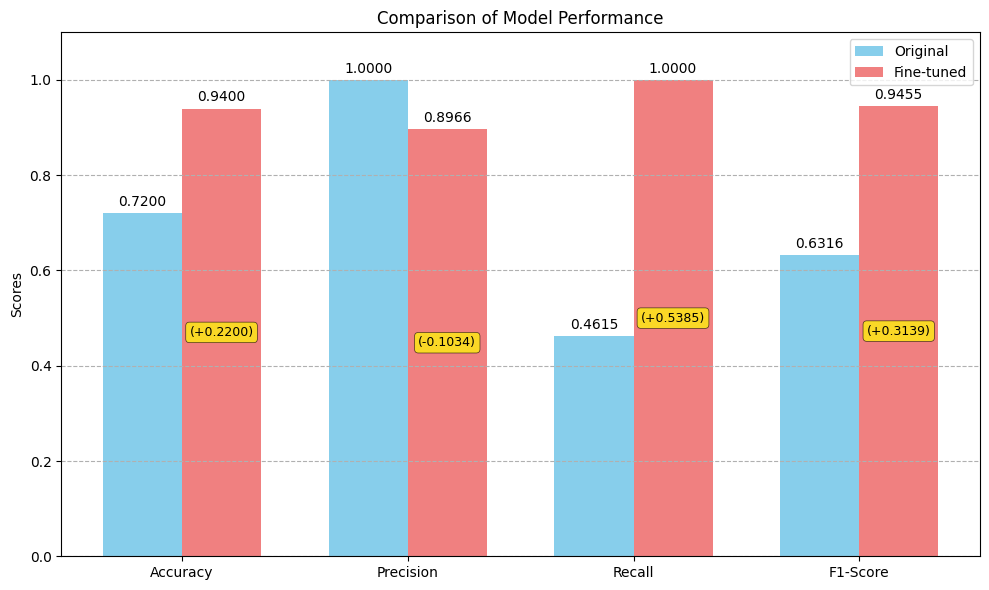

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu từ hình ảnh của bạn
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
original_scores = [0.7200, 1.0000, 0.4615, 0.6316]
fine_tuned_scores = [0.9400, 0.8966, 1.0000, 0.9455]
improvements = [f"+{fine_tuned_scores[i] - original_scores[i]:.4f}" for i in range(len(metrics))]
improvements[1] = f"{fine_tuned_scores[1] - original_scores[1]:.4f}" # Điều chỉnh cho giá trị âm


# Tạo biểu đồ
x = np.arange(len(metrics))  # vị trí của các nhãn
width = 0.35  # độ rộng của các cột

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, original_scores, width, label='Original', color='skyblue')
rects2 = ax.bar(x + width/2, fine_tuned_scores, width, label='Fine-tuned', color='lightcoral')

# Thêm nhãn, tiêu đề và chú thích
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Thêm giá trị trên mỗi cột
def autolabel(rects, improvement_texts=None, is_original=False):
    """Gắn nhãn giá trị lên trên các cột."""
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 điểm offset theo chiều dọc
                    textcoords="offset points",
                    ha='center', va='bottom')
        if not is_original and improvement_texts: # Chỉ thêm improvement cho fine-tuned
            ax.annotate(f'({improvement_texts[i]})',
                        xy=(rect.get_x() + rect.get_width() / 2, height / 2), # Hiển thị ở giữa cột
                        xytext=(0, 0),
                        textcoords="offset points",
                        ha='center', va='center',
                        fontsize=9, color='black',
                        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=0.5, alpha=0.7))


autolabel(rects1, is_original=True)
autolabel(rects2, improvement_texts=improvements)

fig.tight_layout() # Tự động điều chỉnh các tham số để vừa với cửa sổ hình ảnh
plt.ylim(0, 1.1) # Đặt giới hạn cho trục y để dễ so sánh hơn (vì precision có thể là 1.0)
plt.grid(axis='y', linestyle='--') # Thêm lưới ngang để dễ đọc
plt.show()